In [1]:
#import Spark and MLlib packages
from pyspark import SparkContext, SparkConf
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.regression import RidgeRegressionWithSGD
from pyspark.mllib.regression import LassoWithSGD

#import data analysis packages
import numpy as np
import pandas as pd
import sklearn
from pandas import Series, DataFrame
from sklearn.linear_model import LinearRegression
from numpy import array

#import data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#misc packages
from pandas.io.data import DataReader
from datetime import datetime
from __future__ import division
from __future__ import print_function

In [2]:
# load sample dataset from seaborn
tips = sns.load_dataset("tips")

In [3]:
data_size, feature_size = tips.shape
print(data_size, feature_size)

244 7


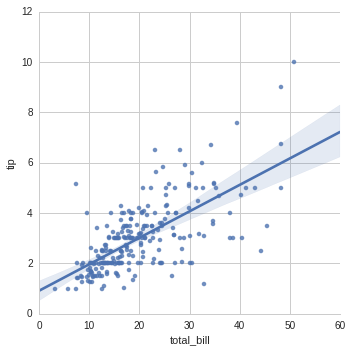

In [4]:
#"total_bill" and "tip" are column name of dataset tips
#fit regression model with simple line
g = sns.lmplot(x="total_bill", y="tip", data=tips)

In [5]:
#Seperate the X and Y axis data
X, Y = tips.total_bill, tips.tip
X = np.vstack(X)

In [6]:
result = np.linalg.lstsq(X,Y)
error_total = result[1]
mse = error_total/len(X)
print(mse)                    

[ 1.17811612]


In [7]:
#Split the dataset as train and test
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X, Y)

In [8]:
#Let's see the size of them
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(183, 1) (61, 1) (183,) (61,)


In [9]:
#Train the linear regression by scikit-learn model
lreg = LinearRegression()
lreg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [10]:
#Predict on training and testing set
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)

In [11]:
#Calculate the root mean square error
print("Fit a model X_train and calculate the MSE with Y_train: %.2f" %np.mean((Y_train-pred_train)**2))
print("Fit a model X_train and calculate the MSE with X_test and Y_test: %.2f" %np.mean((Y_test-pred_test)**2))

Fit a model X_train and calculate the MSE with Y_train: 1.03
Fit a model X_train and calculate the MSE with X_test and Y_test: 1.07


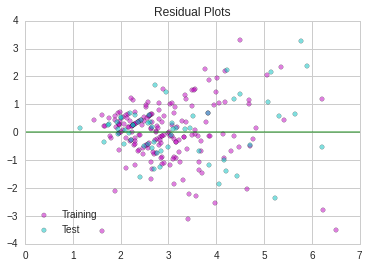

In [12]:
#Scatterly plot the traing data
train = plt.scatter(pred_train, (pred_train-Y_train), c='m', alpha = 0.5)
test = plt.scatter(pred_test, (pred_test-Y_test), c='c', alpha = 0.5)

#Plot a horizontal axis line at y-axis=0
plt.axhline(y=0, xmin=-1, xmax=10, c='g', alpha=0.5)

# Set labels
plt.legend((train,test), ('Training', 'Test'), loc='lower left')
plt.title('Residual Plots')

In [15]:
#dump the tips to a local file for now
Y = np.vstack(Y)
fo = open("/usr/local/spark/examples/src/main/resources/tips.data", "w")
for i in range(data_size):    
    fo.write("{},{}\n".format(float(X[i][0]), float(Y[i][0]))) 

fo.close()

In [16]:
#PySpark Part
sc = SparkContext("local", "tip_linear_regression")

In [17]:
df_RDD = sc.textFile("/usr/local/spark/examples/src/main/resources/tips.data")
#df_RDD = sc.textFile("/usr/local/spark/data/mllib/ridge-data/lpsa.data")

In [18]:
# parase the dataset, replace "," as space
#columns from index 1 will be consider as vectors
def parsePoint(line):
    values = [float(x) for x in line.replace(',', ' ').split(' ')]
    return LabeledPoint(values[0], values[1:])

parsedData = df_RDD.map(parsePoint)

In [19]:
#verify if parsing and map works
#view the first 10 rows. 
parsedData.take(10)

[LabeledPoint(16.99, [1.01]),
 LabeledPoint(10.34, [1.66]),
 LabeledPoint(21.01, [3.5]),
 LabeledPoint(23.68, [3.31]),
 LabeledPoint(24.59, [3.61]),
 LabeledPoint(25.29, [4.71]),
 LabeledPoint(8.77, [2.0]),
 LabeledPoint(26.88, [3.12]),
 LabeledPoint(15.04, [1.96]),
 LabeledPoint(14.78, [3.23])]

In [29]:
def linearRegression_f(mode):
    if   mode == "no_reg":
         model = LinearRegressionWithSGD.train(parsedData)
    elif mode == "L1_reg":
         model = LassoWithSGD.train(parsedData)
    elif mode == "L2_reg":
         model = RidgeRegressionWithSGD.train(parsedData)
    else:
        print("ERROR Mode")
        
    #Evaluate the model on training data
    # parsedData map method to get {train_data, predict_data} pairs 
    valuesAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
    
    #calculate the key-value pairs to get MSE
    MSE = valuesAndPreds.map(lambda (v, p): (v-p)**2).reduce(lambda x, y: x+y)/valuesAndPreds.count()
    
  
    return MSE

In [57]:
valuesAndPreds.take(10)

[(16.99, 6.2672093598464089),
 (10.34, 10.300561918163405),
 (21.01, 21.718052237091516),
 (23.68, 20.53907225850655),
 (24.59, 22.400619593114392),
 (25.29, 29.226293153343157),
 (8.77, 12.410315564052295),
 (26.88, 19.360092279921581),
 (15.04, 12.162109252771248),
 (14.78, 20.042659635944457)]

In [56]:
MSE = linearRegression_f("no_reg")
print("LinearRegression Mean Squared Error = " +str(MSE))

MSE = linearRegression_f("L1_reg")
print("RidgeRegression Mean Squared Error = " +str(MSE))

MSE = linearRegression_f("L2_reg")
print("Lasso Mean Squared Error = " +str(MSE))

LinearRegression Mean Squared Error = 50.8613371293
RidgeRegression Mean Squared Error = 50.8613463067
Lasso Mean Squared Error = 50.8616898496
